In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, rospy, rosbag, glob, re, math

import scipy
import scipy.stats
from scipy.stats import pearsonr

from smap.msg import smapStats

from IPython.display import HTML, display

from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib import cm
from numpy import linspace
from matplotlib.colors import LogNorm
from decimal import *

Minimum Voxels: BSplineTrajectory 500 (16.000000)
Minimum Last AVG Std: BSplineTrajectory 504 (0.058278)
Minimum Last MAX Std: BSplineTrajectory 667 (0.110755)
Minimum Last VAR Reach: BSplineTrajectory 24 (0.000000)
Minimum AVG Future Std: BSplineTrajectory 504 (0.063071)
Minimum AVG(MAX) Future Std: BSplineTrajectory 504 (0.070391)
Minimum MAX Gradient Std: BSplineTrajectory 667 (0.044839)
Minimum Emp. VAR Std: BSplineTrajectory 1010 (0.000298)
Minimum MAX Mean + Std: BSplineTrajectory 525 (0.231431)
Minimum MAX Mean: BSplineTrajectory 696 (0.120676)
Maximum Reach: BSplineTrajectory 500 (0.297372)
Maximum Reach-k*Std (UCB): BSplineTrajectory 500 (0.144963)


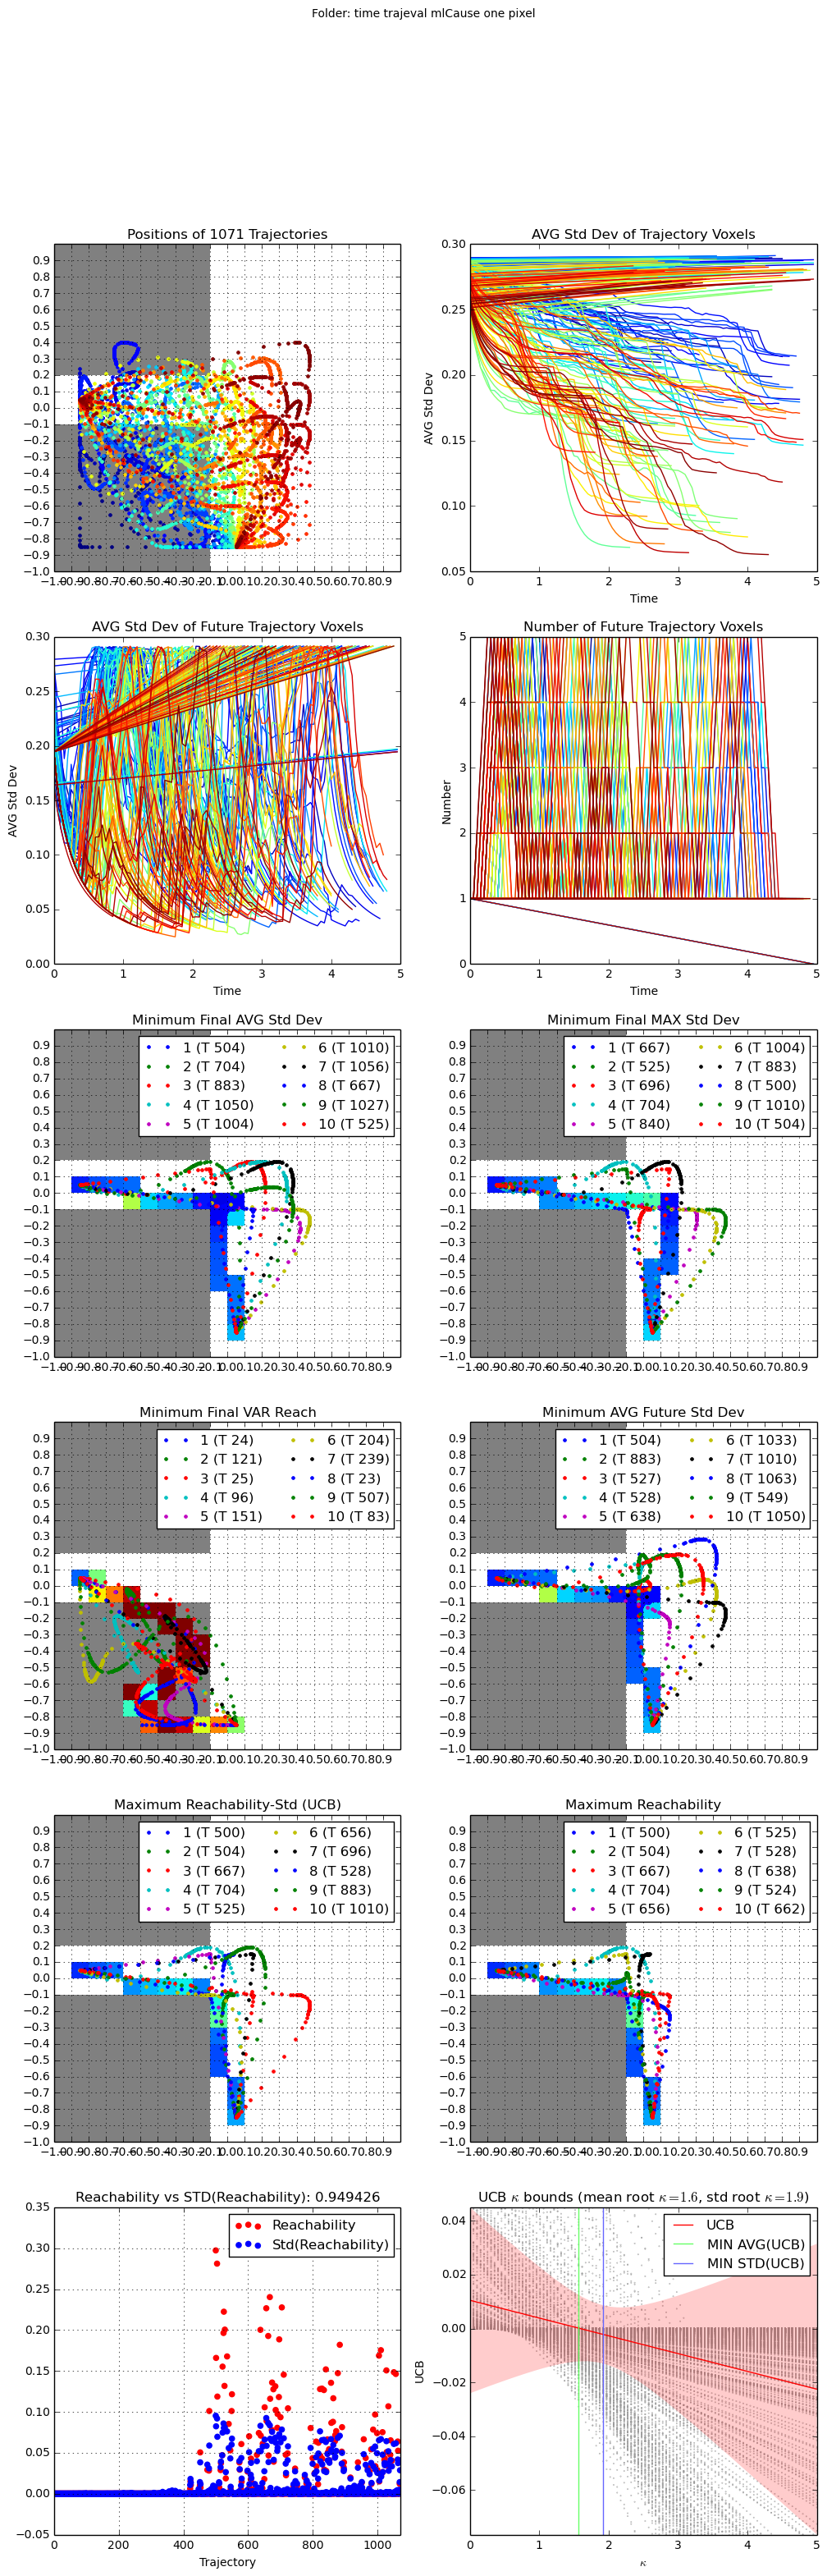

In [7]:
%matplotlib inline

FOLDER_NAME = "time trajeval mlCause one pixel"
SHOW_EVERY_XTH = 10
getcontext().prec = 1024

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12)) = plt.subplots(6, 2, figsize=(12, 36))
fig.suptitle("Folder: %s" % FOLDER_NAME)

verts1 = [
    (-1, -1), # left, bottom
    (-1, -.1), # left, top
    (-.1, -.1), # right, top
    (-.1, -1), # right, bottom
    (0., 0.), # ignored
]

verts2 = [
    (-1, .2), # left, bottom
    (-1, 1), # left, top
    (-.1, 1), # right, top
    (-.1, .2), # right, bottom
    (0., 0.), # ignored
]

codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY,
]

ax1.add_patch(patches.PathPatch(Path(verts1, codes), facecolor='grey', lw=0))
ax1.add_patch(patches.PathPatch(Path(verts2, codes), facecolor='grey', lw=0))
ax1.set_xticks(np.arange(-1,1,0.1))
ax1.set_yticks(np.arange(-1,1,0.1))
ax1.set_xlim([-1, 1])
ax1.set_ylim([-1, 1])
ax1.grid()

# ax10.add_patch(patches.PathPatch(Path(verts1, codes), facecolor='grey', lw=0))
# ax10.add_patch(patches.PathPatch(Path(verts2, codes), facecolor='grey', lw=0))
# ax10.set_xticks(np.arange(-1,1,0.1))
# ax10.set_yticks(np.arange(-1,1,0.1))
# ax10.set_xlim([-1, 1])
# ax10.set_ylim([-1, 1])
# ax10.grid()

filenames = sorted(glob.glob("../build/%s/*.bag" % FOLDER_NAME), key=lambda f: int(re.findall('([0-9]+)', f)[0]))[::1]

cm_subsection = linspace(0, 1, len(filenames))
colors = [cm.jet(x) for x in cm_subsection]


ax1.set_title("Positions of %i Trajectories" % len(filenames))

ax2.set_title("AVG Std Dev of BSplineTrajectory Voxels")
ax2.set_xlabel("Time")
ax2.set_ylabel("AVG Std Dev")

ax3.set_title("AVG Std Dev of Future BSplineTrajectory Voxels")
ax3.set_xlabel("Time")
ax3.set_ylabel("AVG Std Dev")

ax4.set_title("Number of Future BSplineTrajectory Voxels")
ax4.set_xlabel("Time")
ax4.set_ylabel("Number")

traj_names = [""]
avg_stds = []
avg_future_stds = []
max_future_stds = []
max_stds = []
last_var_reachability = []
traj_voxels = []
last_emp_var_stds = []
max_gradient_std = []
max_mean_std = []
max_means = []
max_reaches = []
max_reach_std = []

def argmin(array):
    m = 0
    for i, a in enumerate(array):
        if a < array[m]:
            m = i
    return m

def argmins(array, n=3):
    pairs = sorted(zip(array, range(len(array))), key=lambda x: x[0])
    return list(map(lambda x: x[1], pairs[:n]))

def argmax(array):
    m = 0
    for i, a in enumerate(array):
        if a > array[m]:
            m = i
    return m

def argmaxs(array, n=3):
    pairs = sorted(zip(array, range(len(array))), key=lambda x: x[0], reverse=True)
    return list(map(lambda x: x[1], pairs[:n]))

all_stats = []

def plot_spline(ax, stats, name, rnd, random_color=False):
    if random_color:
        ax.plot(stats.trajectoryX, stats.trajectoryY, '.', label=name)
    else:
        ax.plot(stats.trajectoryX, stats.trajectoryY, '.', label=name, c=colors[rnd])
        
def draw_final_stds(ax, stats, voxel_size=0.1):
    last_stds = stats.trajectoryStdDevsBelief[-stats.trajectoryVoxels:]
    hvoxel_size = voxel_size / 2.
    max_std = max(last_stds)
    for i, std in enumerate(last_stds):
        std *= 4.
        std = min(1., std)
        #print i, "\tstd:", std
        x = stats.trajectoryVoxelX[i]
        y = stats.trajectoryVoxelY[i]
#         if abs(x-0) < 0.2 and abs(y+0.9) < 0.2:
#             continue
        verts = [
            (x - hvoxel_size, y - hvoxel_size), # left, bottom
            (x - hvoxel_size, y + hvoxel_size), # left, top
            (x + hvoxel_size, y + hvoxel_size), # right, top
            (x + hvoxel_size, y - hvoxel_size), # right, bottom
            (0., 0.), # ignored
        ]
        codes = [
            Path.MOVETO,
            Path.LINETO,
            Path.LINETO,
            Path.LINETO,
            Path.CLOSEPOLY,
        ]
        ax.add_patch(patches.PathPatch(Path(verts, codes), facecolor=colors[int(std*(len(filenames)-1))], lw=0))
        
def draw_evaluated(ax, n, ordering, title, show_stds=[]):
    ax.add_patch(patches.PathPatch(Path(verts1, codes), facecolor='grey', lw=0))
    ax.add_patch(patches.PathPatch(Path(verts2, codes), facecolor='grey', lw=0))
    ax.set_xticks(np.arange(-1,1,0.1))
    ax.set_yticks(np.arange(-1,1,0.1))
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.grid()

    for idx in show_stds:
        draw_final_stds(ax, all_stats[ordering[idx]])
        
    ax.set_title(title)
    for i in range(n):
        plot_spline(ax,
                    all_stats[ordering[i]],
                    "%i (T %i)" % (i+1, ordering[i]),
                    ordering[i],
                    True)        
    ax.legend(ncol=2)


for rnd, filename in enumerate(filenames):
    #if rnd != 7:
     #   continue
#     if rnd != 50:
#         continue
    
    #print "Evaluating trajectory %i (%s)..." % (rnd, filename)
    bag = rosbag.Bag(filename)
    stats = None
    for _, msg, _ in bag.read_messages(topics=['stats']):
        stats = msg
    bag.close()
    if stats is None:
        continue
        
    all_stats.append(stats)
        
    traj_names.append("T %i" % rnd)
    traj_voxels.append(stats.trajectoryVoxels)
        
#     start = 0
#     err0sBelief = []
#     err0sLogOdds = []
#     ax = plt.subplot(111)
#     for step in range(stats.step):
#         err0Belief = np.mean(np.array(stats.errorCompleteUpdatedBelief[start:start + stats.updatedVoxels[step]]))
#         err0sBelief.append(err0Belief)
#         err0LogOdds = np.mean(np.array(stats.errorCompleteUpdatedLogOdds[start:start + stats.updatedVoxels[step]]))
#         err0sLogOdds.append(err0LogOdds)
#         start += stats.updatedVoxels[step]
#     ax.plot(err0sBelief, label="SMAP")
#     ax.plot(err0sLogOdds, label="LogOdds")

#     if rnd == 5:
#         ax1.plot(stats.trajectoryX, stats.trajectoryY, label="T %i" % rnd, c=colors[rnd])
    if rnd % SHOW_EVERY_XTH == 0:
        plot_spline(ax1, stats, "T %i" % rnd, rnd)
    
    
    # XXX ignore last 2 steps because of time discontinuity
#     stats.trajectoryTime = stats.trajectoryTime[:-2]
#     stats.trajectoryStdDevsBelief = stats.trajectoryStdDevsBelief[:int(-2*stats.trajectoryVoxels)]
#     stats.trajectoryOccupanciesBelief = stats.trajectoryOccupanciesBelief[:int(-2*stats.trajectoryVoxels)]
    
    lastStdDevs = stats.trajectoryStdDevsBelief[-stats.trajectoryVoxels:]
    lastOccupancies = stats.trajectoryOccupanciesBelief[-stats.trajectoryVoxels:]
#     lastStdDevs = []
#     lastOccupancies = []
    
    # remove voxels close to start, where the std is unnecessarily high
#     skip = []
#     for i in range(stats.trajectoryVoxels):
#         if abs(stats.trajectoryVoxelX[i]-0.) < 0.2 and abs(stats.trajectoryVoxelY[i]+0.9) < 0.2:
#             skip.append(i)
#         else:
#             lastStdDevs.append(lastStdDevs2[i])
#             lastOccupancies.append(lastOccupancies2[i])

    max_gradient_std.append(max(map(lambda (a,b): abs(a-b), zip(lastStdDevs, lastStdDevs[1:]))))
    
    # compute last_var_reachability
    reach_left, reach_right = Decimal(1), Decimal(1)
    max_m_s = 0.
    max_means.append(max(lastOccupancies))
    reach = 1.
    for std, mean in zip(lastStdDevs, lastOccupancies):
        var = Decimal(std) ** Decimal(2)
        mean_sq = Decimal(1.-mean) ** Decimal(2)
        reach_left *= var + mean_sq
        reach_right *= mean_sq
        
        reach *= 1. - mean
        
        max_m_s = max(std + mean, max_m_s)
#         print "reach_left", reach_left
#         print "reach_right", reach_right, "\n"
#         print("Var: %f \tMean: %f" % (var, mean))
#         print("reach_left: %f \treach_right: %f" % (reach_left, reach_right))

    last_var_reachability.append((reach_left - reach_right)) # TODO normalization?
    #print rnd, "last_var_reachability", last_var_reachability[-1]
    
    max_mean_std.append(max_m_s)
    #reach = 1. - reach
    max_reaches.append(reach)
#     KAPPA = Decimal(reach) / last_var_reachability[-1].sqrt()
#     print "KAPPA:", KAPPA
    KAPPA = Decimal(1.6)
    max_reach_std.append(float(Decimal(reach) - last_var_reachability[-1].sqrt() * KAPPA))   
    
    max_stds.append(max(lastStdDevs))
    last_emp_var_stds.append(np.var(lastStdDevs))
    std = np.array(stats.trajectoryStdDevsBelief).reshape((-1, stats.trajectoryVoxels))
    avg_std = np.mean(std, axis=1)
    if rnd % SHOW_EVERY_XTH == 0:
        ax2.plot(stats.trajectoryTime, avg_std, c=colors[rnd])
    
    avg_stds.append(avg_std[-1])      
        
    # future std
    start = 0
    future_avg_stds = []
    max_future_std = 0.
    for step in range(stats.step):
        if stats.trajectoryFutureVoxels[step] > 0:
            future_std = stats.trajectoryFutureStdDevsBelief[start:start + stats.trajectoryFutureVoxels[step]]
            future_mean = stats.trajectoryFutureOccupanciesBelief[start:start + stats.trajectoryFutureVoxels[step]]
            future_avg_stds.append(sum(future_std)*1./stats.trajectoryFutureVoxels[step])
            max_future_std += max(future_std)
            start += stats.trajectoryFutureVoxels[step]
        
    if rnd % SHOW_EVERY_XTH == 0:
        ax3.plot(stats.trajectoryTime[:len(future_avg_stds)], future_avg_stds, c=colors[rnd])
    
    avg_future_std = np.mean(future_avg_stds[:-1])
    avg_future_stds.append(avg_future_std)
    max_future_stds.append(max_future_std / stats.step)
    
    if rnd % SHOW_EVERY_XTH == 0:
        ax4.plot(stats.trajectoryTime, stats.trajectoryFutureVoxels, c=colors[rnd])

n = 10

argmins_avg_stds = argmins(avg_stds, n)
draw_evaluated(ax5, n, argmins_avg_stds, "Minimum Final AVG Std Dev", [0])
               
argmins_max_stds = argmins(max_stds, n)
draw_evaluated(ax6, n, argmins_max_stds, "Minimum Final MAX Std Dev", [0])

argmins_last_var_reachability = argmins(last_var_reachability, n)
draw_evaluated(ax7, n, argmins_last_var_reachability, "Minimum Final VAR Reach", [0])

argmins_avg_future_stds = argmins(avg_future_stds, n)
draw_evaluated(ax8, n, argmins_avg_future_stds, "Minimum AVG Future Std Dev", [0])

argmaxs_max_reach_std = argmaxs(max_reach_std, n)
draw_evaluated(ax9, n, argmaxs_max_reach_std, "Maximum Reachability-Std (UCB)", [0])

# argmins_max_future_stds = argmins(max_future_stds, n)
# draw_evaluated(ax10, n, argmins_max_future_stds, "Minimum AVG(MAX) Future Std Dev", [0])

argmaxs_max_reaches = argmaxs(max_reaches, n)
draw_evaluated(ax10, n, argmaxs_max_reaches, "Maximum Reachability", [0])

ax11.scatter(list(range(len(max_reaches))), max_reaches, label="Reachability", color="r")
std_reachability = np.array(list(map(lambda x: float(x.sqrt()), last_var_reachability)))
ax11.scatter(list(range(len(std_reachability))), std_reachability, label="Std(Reachability)", color="b")
pcc, _ = pearsonr(max_reaches, std_reachability)
ax11.set_title("Reachability vs STD(Reachability): %.6f" % pcc)
ax11.set_xlabel("BSplineTrajectory")
ax11.set_xlim([0, len(last_var_reachability)])
ax11.legend()
ax11.grid()

kappas = np.linspace(0, 5, 100)
# ax12.scatter(kappas, [np.mean(np.array(max_reaches) - std_reachability * kappa) for kappa in kappas], label="UCB", color="r")
mean_ucb = np.array([np.mean(np.array(max_reaches) - std_reachability * kappa) for kappa in kappas])
kappa_root = np.argmin(np.abs(mean_ucb))
std_ucb = np.array([np.std(np.array(max_reaches) - std_reachability * kappa) for kappa in kappas])
kappa_stdroot = np.argmin(std_ucb)
for kappa in kappas:
    ax12.scatter([kappa] * len(max_reaches), np.array(max_reaches) - std_reachability * kappa, color="#999999", s=0.1)
ax12.fill_between(kappas, mean_ucb - std_ucb, mean_ucb + std_ucb, facecolor='r', alpha=0.2, edgecolor='none', antialiased=True)
ax12.plot(kappas, mean_ucb, label="UCB", color="r")
ax12.plot([kappas[kappa_root], kappas[kappa_root]], [-1, 1], color="#66ff66", label="MIN AVG(UCB)")
ax12.plot([kappas[kappa_stdroot], kappas[kappa_stdroot]], [-1, 1], color="#6666ff", label="MIN STD(UCB)")
# ax12.scatter(list(range(len(std_reachability))), last_var_reachability, label="VAR(Reachability)", color="b")
# pcc, _ = pearsonr(max_reaches, std_reachability)
ax12.set_title("UCB $\kappa$ bounds (mean root $\kappa=%.1f$, std root $\kappa=%.1f$)" % (kappas[kappa_root], kappas[kappa_stdroot]))
ax12.set_xlabel("$\kappa$")
ax12.set_xlim([np.min(kappas), np.max(kappas)])
ax12.set_ylim([np.min(mean_ucb - std_ucb), np.max(mean_ucb + std_ucb)])
ax12.set_ylabel("UCB")
ax12.legend()

# argmins_max_gradient_std = argmins(max_gradient_std, n)
# draw_evaluated(ax10, n, argmins_max_gradient_std, "Minimum MAX Gradient Std Dev", [0])

# draw_final_stds(ax10, all_stats[52])
# plot_spline(ax10, all_stats[52], "T 52", 52, True)    
# ax10.legend()

def generate_row(title, numbers, highlight_min=True, highlight_max=False):
    min_n = min(numbers)
    max_n = max(numbers)
    if highlight_min:
        print "Minimum %s: BSplineTrajectory %i (%.6f)" % (title, argmin(numbers), min_n)
    if highlight_max:
        print "Maximum %s: BSplineTrajectory %i (%.6f)" % (title, argmax(numbers), max_n)
    row = '<th>%s</th>' % title
    for n in numbers:
        if (highlight_min and n == min_n) or (highlight_max and n == max_n):
            row += '<td style="background:#ff0;text-align:right"><b>%.3f</b></td>' % n
        else:
            row += '<td style="text-align:right">%.3f</td>' % n
    return row

data = [
    '<th>{}</th>'.format('</th><th>'.join(traj_names)),
    generate_row("Voxels", traj_voxels),
    generate_row("Last AVG Std", avg_stds),
    generate_row("Last MAX Std", max_stds),
    generate_row("Last VAR Reach", last_var_reachability),
    generate_row("AVG Future Std", avg_future_stds),
    generate_row("AVG(MAX) Future Std", max_future_stds),
    generate_row("MAX Gradient Std", max_gradient_std),
    generate_row("Emp. VAR Std", last_emp_var_stds),
    generate_row("MAX Mean + Std", max_mean_std),
    generate_row("MAX Mean", max_means),
    generate_row("Reach", max_reaches, highlight_max=True, highlight_min=False),
    generate_row("Reach-k*Std (UCB)", max_reach_std, highlight_max=True, highlight_min=False)
]

display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(data)
        )
 ))

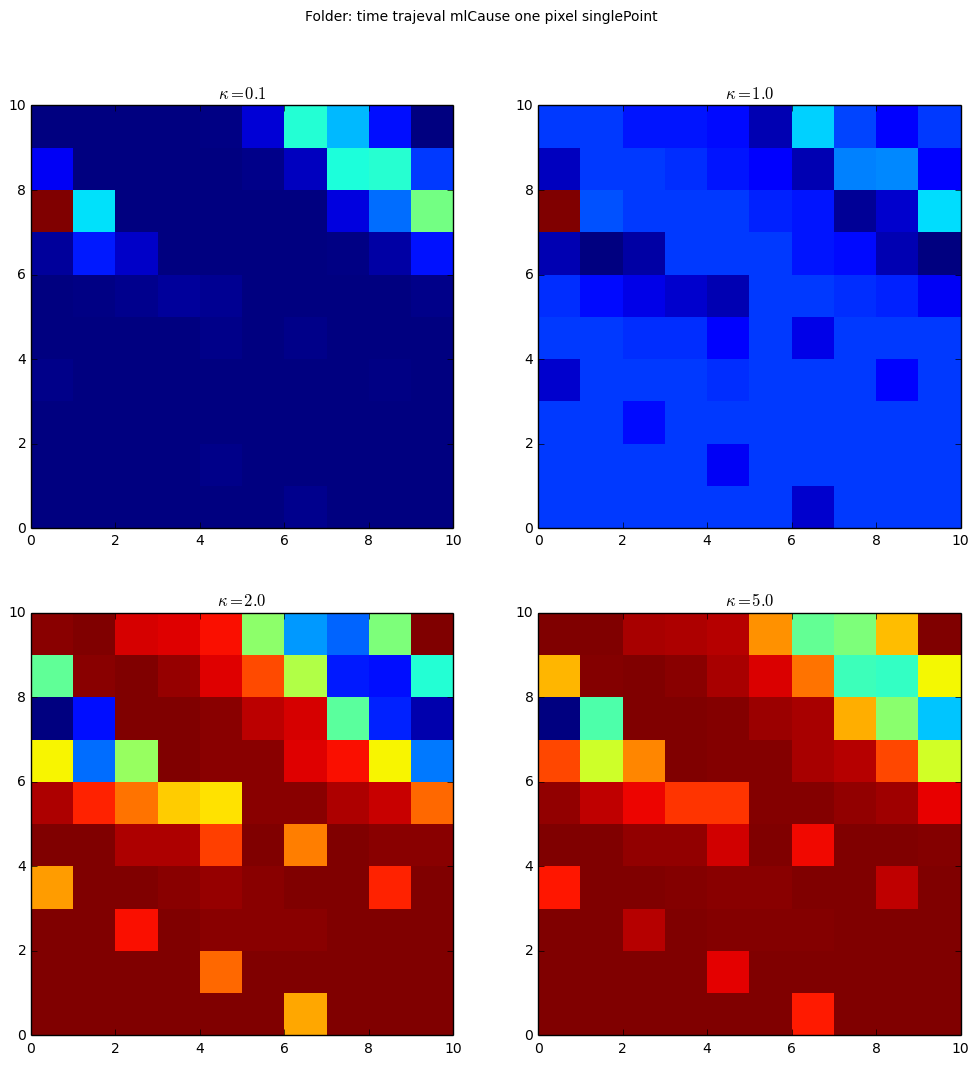

In [56]:
%matplotlib inline

FOLDER_NAME = "time trajeval mlCause one pixel singlePoint"
SHOW_EVERY_XTH = 10
getcontext().prec = 1024

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Folder: %s" % FOLDER_NAME)

filenames = sorted(glob.glob("../build/%s/*.bag" % FOLDER_NAME), key=lambda f: int(re.findall('([0-9]+)', f)[0]))[::1]

cm_subsection = linspace(0, 1, len(filenames))
colors = [cm.jet(x) for x in cm_subsection]

traj_names = [""]
avg_stds = []
avg_future_stds = []
max_future_stds = []
max_stds = []
last_var_reachability = []
traj_voxels = []
last_emp_var_stds = []
max_gradient_std = []
max_mean_std = []
max_means = []
max_reaches = []
max_reach_std = []
all_stats = []
     
def draw_evaluated(ax, n, ordering, title, show_stds=[]):
    ax.add_patch(patches.PathPatch(Path(verts1, codes), facecolor='grey', lw=0))
    ax.add_patch(patches.PathPatch(Path(verts2, codes), facecolor='grey', lw=0))
    ax.set_xticks(np.arange(-1,1,0.1))
    ax.set_yticks(np.arange(-1,1,0.1))
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.grid()

    for idx in show_stds:
        draw_final_stds(ax, all_stats[ordering[idx]])
        
    ax.set_title(title)
    for i in range(n):
        plot_spline(ax,
                    all_stats[ordering[i]],
                    "%i (T %i)" % (i+1, ordering[i]),
                    ordering[i],
                    True)        
    ax.legend(ncol=2)

grid = []

pointStats = {}
kappas = [0.1, 1, 2, 5]
xs = []
ys = []
zs = []

c = []
lastx = -1000

for rnd, filename in enumerate(filenames):
    #if rnd != 7:
     #   continue
#     if rnd != 50:
#         continue
    
    #print "Evaluating trajectory %i (%s)..." % (rnd, filename)
    bag = rosbag.Bag(filename)
    stats = None
    for _, msg, _ in bag.read_messages(topics=['stats']):
        stats = msg
    bag.close()
    if stats is None:
        continue    
    
    # XXX ignore last 2 steps because of time discontinuity
#     stats.trajectoryTime = stats.trajectoryTime[:-2]
#     stats.trajectoryStdDevsBelief = stats.trajectoryStdDevsBelief[:int(-2*stats.trajectoryVoxels)]
#     stats.trajectoryOccupanciesBelief = stats.trajectoryOccupanciesBelief[:int(-2*stats.trajectoryVoxels)]
    
    lastStdDevs = stats.trajectoryStdDevsBelief[-stats.trajectoryVoxels:]
    lastOccupancies = stats.trajectoryOccupanciesBelief[-stats.trajectoryVoxels:]
#     lastStdDevs = []
#     lastOccupancies = []
    
    # remove voxels close to start, where the std is unnecessarily high
#     skip = []
#     for i in range(stats.trajectoryVoxels):
#         if abs(stats.trajectoryVoxelX[i]-0.) < 0.2 and abs(stats.trajectoryVoxelY[i]+0.9) < 0.2:
#             skip.append(i)
#         else:
#             lastStdDevs.append(lastStdDevs2[i])
#             lastOccupancies.append(lastOccupancies2[i])

    max_gradient_std.append(max(map(lambda (a,b): abs(a-b), zip(lastStdDevs, lastStdDevs[1:]))))
    
    # compute last_var_reachability
    reach_left, reach_right = Decimal(1), Decimal(1)
    max_m_s = 0.
    max_means.append(max(lastOccupancies))
    reach = 1.
    for std, mean in zip(lastStdDevs, lastOccupancies):
        var = Decimal(std) ** Decimal(2)
        mean_sq = Decimal(1.-mean) ** Decimal(2)
        reach_left *= var + mean_sq
        reach_right *= mean_sq
        
        reach *= 1. - mean
        
        max_m_s = max(std + mean, max_m_s)
#         print "reach_left", reach_left
#         print "reach_right", reach_right, "\n"
#         print("Var: %f \tMean: %f" % (var, mean))
#         print("reach_left: %f \treach_right: %f" % (reach_left, reach_right))

    last_var_reachability.append((reach_left - reach_right)) # TODO normalization?
    #print rnd, "last_var_reachability", last_var_reachability[-1]
    
    max_mean_std.append(max_m_s)
    #reach = 1. - reach
    max_reaches.append(reach)
#     KAPPA = Decimal(reach) / last_var_reachability[-1].sqrt()
#     print "KAPPA:", KAPPA
    ucb = [float(Decimal(reach) - last_var_reachability[-1].sqrt() * Decimal(kappa)) for kappa in kappas]
    
    xs.append(stats.trajectoryX[int(len(stats.trajectoryX)/2)])
    ys.append(stats.trajectoryY[int(len(stats.trajectoryY)/2)])    
    zs.append(ucb)
    

# print "xs", xs.shape
# print "ys", ys.shape
# print "zs", zs.shape

# from scipy.interpolate import griddata

# X = np.linspace(xs.min(), xs.max(), 1000)
# Y = np.linspace(ys.min(), ys.max(), 1000)
# Z = griddata((xs, ys), zs, (X[None,:], Y[:,None]), method='cubic')

# print Z.shape

# ax1.contourf(X, Y, Z, 15, cmap=plt.cm.rainbow)

# a = []
# c = []
# lastx = -1000
# for x,y,z in zip(xs, ys, zs):
#     if x >= lastx:
#         c.append(z)
#     else:
#         a.append(c)
#         c = [z]
#     lastx = x
# a.append(c)
# a = np.array(a)
# print a.shape
zs.append([0] * len(kappas))
for i, (k,ax) in enumerate(zip(kappas, [ax1, ax2, ax3, ax4])):
    Z = np.array(list(map(lambda x: x[i], zs)))
    Z = Z.transpose().reshape((10, -1)) * 3000
    ax.pcolor(Z.astype(int))
    ax.set_title("$\kappa = %.1f$" % k)